# Expression levels of DEGs in 24h dNipBL and proximity to enhancers

***Purpose:*** To get more granularity on patterns of expression with respect to proximity to enhancers and TAD compartmentalization by looking at base-level expression. Aiming to answer questions such as: does adding a threshold cut-off for WT expression make the observed patterns more apparent? Do down-regulated genes seem more similar to non-significant genes that have high levels of expression?

**Process:** Plotting across the following variables:
* Histogram of expression levels for all genes, and within each category (up/down/non-sign.)
* Using threshold cut-off to see distribution of [num enhancers/TAD] vs [num. genes/TAD]

## Note/todo:

include 'and proximity to other features' in this notebook? Or --> do separately

In [32]:
import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [33]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Load data and project files

In [34]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"
# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'
feature_counts = '20220816_featureCounts.csv'
vst_normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv'
WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

# import results table
day1_res_df = pd.read_csv(proj+day1_sigRes)

# add feature counts information to label genes not in the significant results table
feat_counts_df = pd.read_csv(proj+feature_counts)
day1_res_df = day1_res_df.merge(feat_counts_df['Geneid'], how='outer')

### Merging average normalized feature counts and average vst-normalized feature counts into results table

In [35]:
# import table of raw feature counts and calculate average
feat_counts_df = pd.read_csv(proj+feature_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
feat_counts_df['avg'] = feat_counts_df[WT_samples].mean(axis='columns')

# import table of normalized feature counts and calculate average
vst_counts_df = pd.read_csv(proj+vst_normalized_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
vst_counts_df['avg'] = vst_counts_df[WT_samples].mean(axis='columns')

feat_counts_df = feat_counts_df.merge(vst_counts_df, on='Geneid', how='left', suffixes=('_counts', '_vst_counts'))
feat_counts_df['avg_vst_counts'].fillna(feat_counts_df['avg_counts'], inplace=True)

# add average normalized counts value to results df
day1_res_df = day1_res_df.merge(feat_counts_df[['Geneid', 'avg_vst_counts', 'avg_counts']], on='Geneid', how='outer')

### Add feature annotations to gene set: TSS locations, DE status label, distance to closest enhancer

In [36]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))
# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


Checking for 'lost' significant genes: 
lost:  0


### import enhancer files

In [37]:
dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'

chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
# whythe_reg = 'remapped_enhancers_Whyte_2013_mm9.bed.txt' <-- where is this?

enhancers = {'chen_s1' : dataset_folder+chen_s1,
             'wythe_super' : dataset_folder+whythe_super}

### label distance to closest enhancer for each gene

In [38]:
for label, file in enhancers.items():
    day1_res_df = flt.label_closest_enhancer(day1_res_df, file, label)

In [39]:
print('how many genes did not receive an enhancer label --> dropped')
print((day1_res_df['chen_s1_distance'].isna() |
       day1_res_df['wythe_super_distance'].isna()
      ).sum())
day1_res_df.dropna(subset=
                   ['chen_s1_distance', 
                    'wythe_super_distance'], 
                   inplace=True
                  )

how many genes did not receive an enhancer label --> dropped
55


# Distribution of WT expression levels

### Average Counts -- not normalized

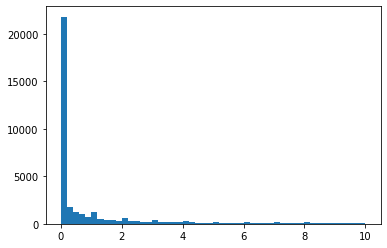

In [9]:
plt.hist(day1_res_df['avg_counts'].values, range=(0, 10), bins=50)
plt.show()

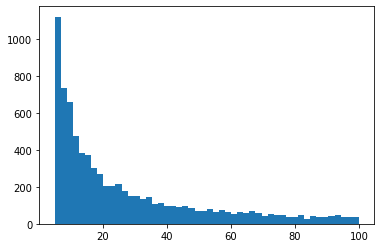

In [10]:
plt.hist(day1_res_df['avg_counts'].values, range=(5, 100), bins=50)
plt.show()

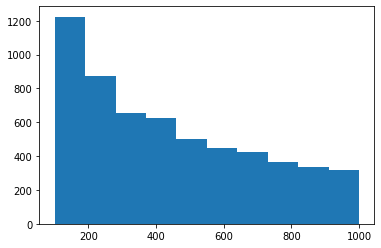

In [11]:
plt.hist(day1_res_df['avg_counts'].values, range=(100, 1000))
plt.show()

### average vst-normalized counts

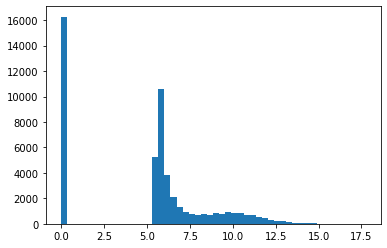

In [12]:
plt.hist(day1_res_df['avg_vst_counts'].values, bins=50)
plt.show()

In [19]:
import importlib
importlib.reload(pfn)

<module 'plotting_histogram_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py'>

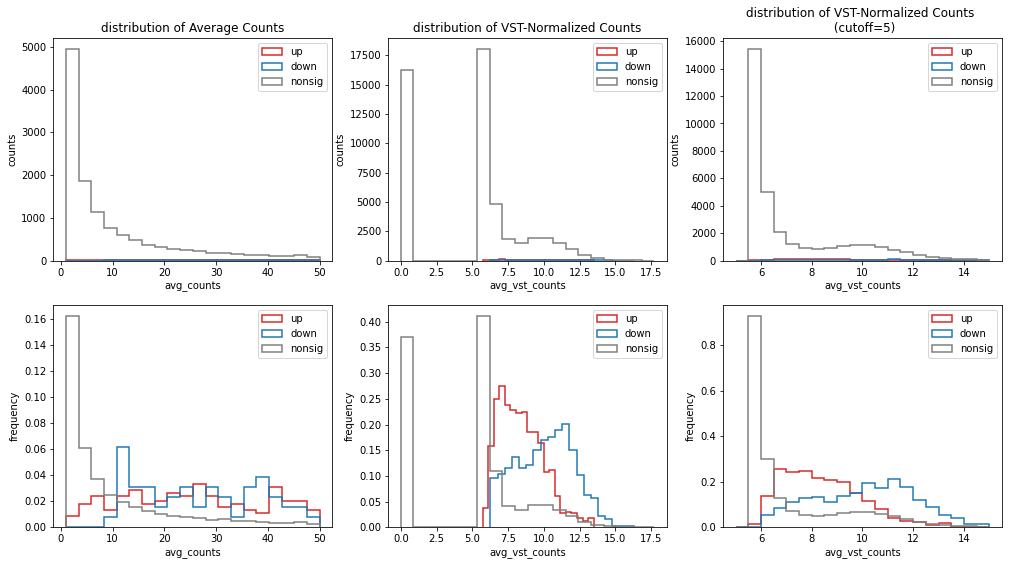

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(17, 9))

plot_vars = [{'title': 'distribution of Average Counts',
              'col' : 'avg_counts',
              'range' : (1, 50),
              'ax1' : 0},
             {'title': 'distribution of VST-Normalized Counts',
              'col' : 'avg_vst_counts',
              'range' : None,
              'ax1' : 1},
             {'title': 'distribution of VST-Normalized Counts \n (cutoff=5)',
              'col' : 'avg_vst_counts',
              'range' : (5, 15),
              'ax1' : 2}]

for params in plot_vars:
    pfn.plot_categorized_histogram(day1_res_df, 
                            params['col'],
                            bins=20,
                            plot_title=params['title'],
                            val_range=params['range'],
                            ax=axs[0, params['ax1']])
    pfn.plot_categorized_histogram(day1_res_df, 
                            params['col'],
                            density=True,
                            bins=20,
                            val_range=params['range'],
                            ax=axs[1, params['ax1']])

## Observations:

It looks like the vst-normalized counts may have already enforced a threshold cut-off when exporting the results table from DESeq2. We'll start this threshold at vst_counts=5, and try some others as well.

# Enhancer concentration compared to gene distribution within TAD Boundaries

* Investigating gene dysregulation relative to enhancers + HiC
* To answer question: How many dysregulated genes contain a distal enhancer in the same TAD?

### Load Hi-C data

Process insulation boundaries to represent TADs as genomic intervals

In [22]:
import importlib
importlib.reload(flt)

<module 'filter_gene_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/filter_gene_functions.py'>

In [23]:
# load features for boundaries
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

tad_df = flt.tad_windows_from_boundaries(insulation_table)

# Plot number of enhancers and distribution of genes within each TAD

### Using the following variations:

- midpoint between insulation boundaries to define TAD windows
- non-significant genes separated by quartiles
- up- and down- reg genes separated by quartiles
- including lower-bound of expression cut-offs based on avg-vst signal: 5.0, 5.5, 6.0, 6.5, 7.0

In [46]:
# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# label quantiles for non-significant genes
nonsig_quant_df = day1_res_df.copy()
nonsig_quant_df = flt.label_quantiles(nonsig_quant_df)

category_colormap = {'up' : 'r',
                         'down' : 'b',
                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

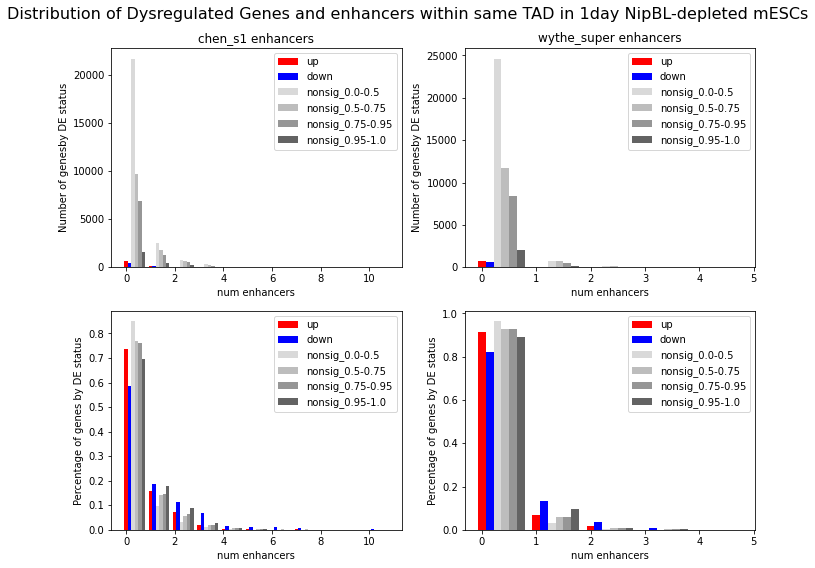

In [49]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 nonsig_quant_df,
                                 feature_category_colors=category_colormap,
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        nonsig_quant_df,
                                        plot_title='',
                                        feature_category_colors=category_colormap,
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

In [56]:
# label quartiles (with default q_array = [0, .5, .75, .95, 1.])
quantiled_df = nonsig_quant_df.copy()

quantiled_df = flt.label_quantiles(quantiled_df, label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='down')

category_colormap_big = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',

                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

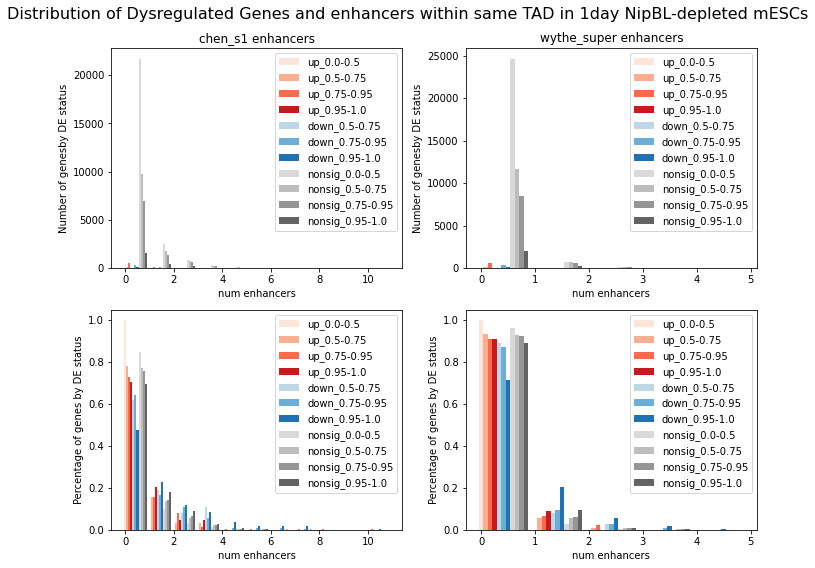

In [57]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 quantiled_df,
                                 feature_category_colors=category_colormap_big,
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        quantiled_df,
                                        plot_title='',
                                        feature_category_colors=category_colormap_big,
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

In [55]:
quantiled_df['DE_status'].value_counts()

nonsig_0.0-0.5      25528
nonsig_0.5-0.75     12602
nonsig_0.75-0.95     9099
nonsig_0.95-1.0      2262
up_0.75-0.95          669
down_0.75-0.95        443
down_0.95-1.0         247
up_0.5-0.75           123
up_0.95-1.0            44
down_0.5-0.75          37
up_0.0-0.5              1
Name: DE_status, dtype: int64

In [58]:
# todo: next, thresholds!!!!

